## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [6]:
X_trains = X_trains.astype('float32') / 255.
TEST = TEST.astype('float32') / 255.

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D,Flatten, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, MaxPool2D,Activation, Dropout,UpSampling2D, GlobalAveragePooling2D, Dense ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

### ResNet

In [8]:
def ResNet(shape = (28,28,3)):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    inputs = Input(shape)
    
    # CNN
    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(inputs) 
    
    conv_2_1 = Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(conv_1)
    conv_2_1 = Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = add([conv_1, conv_2_1])
    out_2_1 = Activation('relu')(add_2_1)
    
    conv_2_2 = Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu')(out_2_1)
    conv_2_2 = Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = add([out_2_1, conv_2_2])
    out_2_2 = Activation('relu')(add_2_1)
    
    pool_2 = MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = Conv2D(256, kernel_size = 1, strides = 1)(pool_2)
    
    conv_3_1 = Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_3_0)
    conv_3_1 = Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = add([conv_3_0, conv_3_1])
    out_3_1 = Activation('relu')(add_3_1)
    
    conv_3_2 = Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(out_3_1)
    conv_3_2 = Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = add([out_3_1, conv_3_2])
    out_3_2 = Activation('relu')(add_3_2)
    
    pool_3 = MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu')(conv_4_0)
    conv_4_1 = Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = add([conv_4_0, conv_4_1])
    out_4_1 = Activation('relu')(add_4_1)
    
    pool_4 = MaxPool2D((2,2), strides = 2)(out_4_1)
    
    # FC layers
    img_features = Flatten()(pool_4)
    img_features = Dense(512, activation = 'relu')(img_features)
    img_features = Dropout(rate = 0.5)(img_features)
    img_features = Dense(512, activation = 'relu')(img_features)
    img_features = Dropout(rate = 0.5)(img_features)
    
    # Output layer
    outputs = Dense(10, activation = 'softmax')(img_features)
    
    model = Model(inputs = inputs, outputs = outputs)
                    
    return model

In [9]:
model = ResNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  147584      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [11]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 300
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/300
54/56 [===========================>..] - ETA: 0s - loss: 2.3135 - accuracy: 0.1007
Epoch 00001: val_loss improved from inf to 2.29379, saving model to model1_best_0.h5
56/56 [==============================] - 2s 29ms/step - loss: 2.3137 - accuracy: 0.1004 - val_loss: 2.2938 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3007 - accuracy: 0.1063
Epoch 00002: val_loss improved from 2.29379 to 2.29309, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.3011 - accuracy: 0.1049 - val_loss: 2.2931 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2988 - accuracy: 0.1040
Epoch 00003: val_loss improved from 2.29309 to 2.28209, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.2992 - accuracy: 0.1049 - val_loss:

Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.5211 - accuracy: 0.4653
Epoch 00026: val_loss improved from 1.14468 to 1.14374, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 1.5231 - accuracy: 0.4648 - val_loss: 1.1437 - val_accuracy: 0.6094 - lr: 1.0000e-04
Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4806 - accuracy: 0.4818
Epoch 00027: val_loss improved from 1.14374 to 1.05816, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 1.4792 - accuracy: 0.4838 - val_loss: 1.0582 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.4202 - accuracy: 0.5125
Epoch 00028: val_loss did not improve from 1.05816
56/56 [==============================] - 1s 22ms/step - loss: 1.4243 - accuracy: 0.5112 - val_loss: 1.1037 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 29/300
54/56 [======================

55/56 [============================>.] - ETA: 0s - loss: 0.8525 - accuracy: 0.7063
Epoch 00053: val_loss did not improve from 0.75594
56/56 [==============================] - 1s 23ms/step - loss: 0.8553 - accuracy: 0.7037 - val_loss: 0.8408 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 0.8348 - accuracy: 0.7205
Epoch 00054: val_loss did not improve from 0.75594
56/56 [==============================] - 1s 22ms/step - loss: 0.8344 - accuracy: 0.7215 - val_loss: 0.8608 - val_accuracy: 0.7539 - lr: 1.0000e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.8330 - accuracy: 0.7188
Epoch 00055: val_loss did not improve from 0.75594
56/56 [==============================] - 1s 22ms/step - loss: 0.8264 - accuracy: 0.7215 - val_loss: 0.8374 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.8317 - accuracy: 0.7170
Epoch 00056: val_loss did not impro

55/56 [============================>.] - ETA: 0s - loss: 0.5744 - accuracy: 0.8097
Epoch 00080: val_loss did not improve from 0.61527
56/56 [==============================] - 1s 23ms/step - loss: 0.5789 - accuracy: 0.8064 - val_loss: 0.6863 - val_accuracy: 0.8242 - lr: 1.0000e-04
Epoch 81/300
55/56 [============================>.] - ETA: 0s - loss: 0.6007 - accuracy: 0.8000
Epoch 00081: val_loss improved from 0.61527 to 0.56094, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 0.5983 - accuracy: 0.8013 - val_loss: 0.5609 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 82/300
55/56 [============================>.] - ETA: 0s - loss: 0.6195 - accuracy: 0.7937
Epoch 00082: val_loss did not improve from 0.56094
56/56 [==============================] - 1s 23ms/step - loss: 0.6207 - accuracy: 0.7924 - val_loss: 0.7918 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 83/300
55/56 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.79

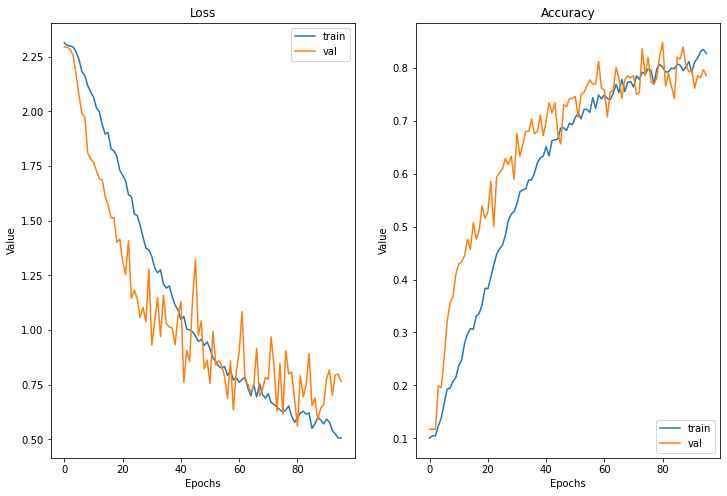

*******************number_2_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3086 - accuracy: 0.0886
Epoch 00001: val_loss improved from inf to 2.29160, saving model to model1_best_0.h5
56/56 [==============================] - 2s 27ms/step - loss: 2.3090 - accuracy: 0.0882 - val_loss: 2.2916 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3006 - accuracy: 0.1097
Epoch 00002: val_loss improved from 2.29160 to 2.28089, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.3009 - accuracy: 0.1105 - val_loss: 2.2809 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2969 - accuracy: 0.1131
Epoch 00003: val_loss improved from 2.28089 to 2.26432, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 2.2968 - accuracy: 0.1133 - val_loss:

55/56 [============================>.] - ETA: 0s - loss: 1.4344 - accuracy: 0.5051
Epoch 00026: val_loss did not improve from 0.84885
56/56 [==============================] - 1s 23ms/step - loss: 1.4339 - accuracy: 0.5061 - val_loss: 1.0221 - val_accuracy: 0.6602 - lr: 1.0000e-04
Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.3992 - accuracy: 0.5330
Epoch 00027: val_loss improved from 0.84885 to 0.78710, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 1.4033 - accuracy: 0.5301 - val_loss: 0.7871 - val_accuracy: 0.7461 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.3708 - accuracy: 0.5335
Epoch 00028: val_loss did not improve from 0.78710
56/56 [==============================] - 1s 23ms/step - loss: 1.3751 - accuracy: 0.5324 - val_loss: 1.0096 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 29/300
55/56 [============================>.] - ETA: 0s - loss: 1.3238 - accuracy: 0.54

Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 0.8417 - accuracy: 0.7250
Epoch 00053: val_loss did not improve from 0.50595
56/56 [==============================] - 1s 23ms/step - loss: 0.8387 - accuracy: 0.7254 - val_loss: 0.5969 - val_accuracy: 0.7930 - lr: 1.0000e-04
Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 0.8067 - accuracy: 0.7358
Epoch 00054: val_loss did not improve from 0.50595
56/56 [==============================] - 1s 23ms/step - loss: 0.8067 - accuracy: 0.7355 - val_loss: 0.6658 - val_accuracy: 0.8047 - lr: 1.0000e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.8362 - accuracy: 0.7182
Epoch 00055: val_loss improved from 0.50595 to 0.46653, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 0.8359 - accuracy: 0.7193 - val_loss: 0.4665 - val_accuracy: 0.8477 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.8368 - a

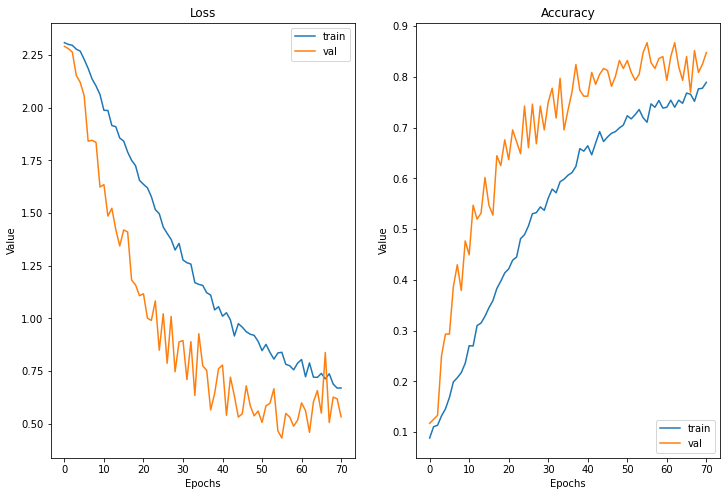

*******************number_3_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3054 - accuracy: 0.1153
Epoch 00001: val_loss improved from inf to 2.30189, saving model to model1_best_0.h5
56/56 [==============================] - 2s 28ms/step - loss: 2.3049 - accuracy: 0.1150 - val_loss: 2.3019 - val_accuracy: 0.1094 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3021 - accuracy: 0.1148
Epoch 00002: val_loss improved from 2.30189 to 2.29913, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 2.3023 - accuracy: 0.1133 - val_loss: 2.2991 - val_accuracy: 0.1211 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.3031 - accuracy: 0.1097
Epoch 00003: val_loss improved from 2.29913 to 2.29596, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.3029 - accuracy: 0.1105 - val_loss:

Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.5080 - accuracy: 0.4739
Epoch 00026: val_loss improved from 1.04677 to 0.99894, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 1.5067 - accuracy: 0.4743 - val_loss: 0.9989 - val_accuracy: 0.6836 - lr: 1.0000e-04
Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4460 - accuracy: 0.5063
Epoch 00027: val_loss did not improve from 0.99894
56/56 [==============================] - 1s 20ms/step - loss: 1.4455 - accuracy: 0.5067 - val_loss: 1.0000 - val_accuracy: 0.6836 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.3992 - accuracy: 0.5051
Epoch 00028: val_loss improved from 0.99894 to 0.91562, saving model to model1_best_0.h5
56/56 [==============================] - 1s 22ms/step - loss: 1.4017 - accuracy: 0.5050 - val_loss: 0.9156 - val_accuracy: 0.7070 - lr: 1.0000e-04
Epoch 29/300
55/56 [======================

Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 0.8728 - accuracy: 0.7153
Epoch 00053: val_loss did not improve from 0.52874
56/56 [==============================] - 1s 20ms/step - loss: 0.8673 - accuracy: 0.7171 - val_loss: 0.8713 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 0.8367 - accuracy: 0.7023
Epoch 00054: val_loss did not improve from 0.52874
56/56 [==============================] - 1s 20ms/step - loss: 0.8324 - accuracy: 0.7031 - val_loss: 0.5655 - val_accuracy: 0.8398 - lr: 1.0000e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.7964 - accuracy: 0.7324
Epoch 00055: val_loss did not improve from 0.52874
56/56 [==============================] - 1s 20ms/step - loss: 0.7965 - accuracy: 0.7321 - val_loss: 0.7969 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.7727 - accuracy: 0.7455
Epoch 00056: val_loss 

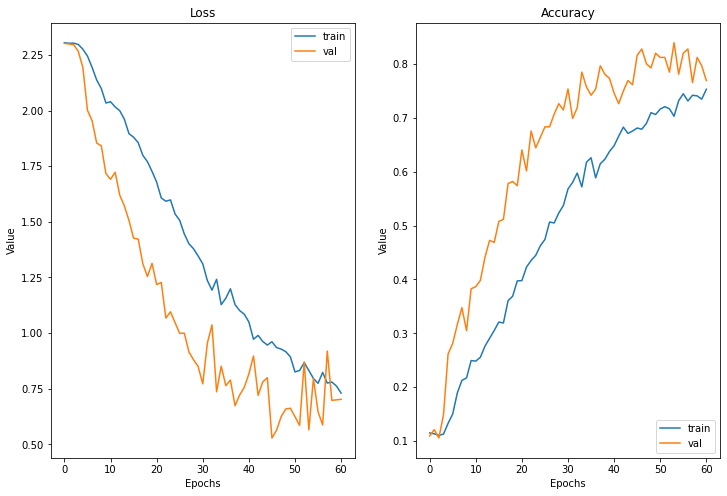

*******************number_4_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3043 - accuracy: 0.1187
Epoch 00001: val_loss improved from inf to 2.29376, saving model to model1_best_0.h5
56/56 [==============================] - 1s 24ms/step - loss: 2.3045 - accuracy: 0.1166 - val_loss: 2.2938 - val_accuracy: 0.1016 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3042 - accuracy: 0.1017
Epoch 00002: val_loss improved from 2.29376 to 2.29246, saving model to model1_best_0.h5
56/56 [==============================] - 1s 22ms/step - loss: 2.3043 - accuracy: 0.1010 - val_loss: 2.2925 - val_accuracy: 0.1406 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2989 - accuracy: 0.1114
Epoch 00003: val_loss improved from 2.29246 to 2.27024, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 2.2993 - accuracy: 0.1122 - val_loss:

55/56 [============================>.] - ETA: 0s - loss: 1.4904 - accuracy: 0.4773
Epoch 00026: val_loss did not improve from 0.97601
56/56 [==============================] - 1s 20ms/step - loss: 1.4873 - accuracy: 0.4771 - val_loss: 1.1872 - val_accuracy: 0.6055 - lr: 1.0000e-04
Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4786 - accuracy: 0.4949
Epoch 00027: val_loss improved from 0.97601 to 0.83702, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 1.4780 - accuracy: 0.4967 - val_loss: 0.8370 - val_accuracy: 0.7383 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.4424 - accuracy: 0.5142
Epoch 00028: val_loss improved from 0.83702 to 0.83316, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 1.4357 - accuracy: 0.5173 - val_loss: 0.8332 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 29/300
55/56 [============================>.] - E

55/56 [============================>.] - ETA: 0s - loss: 0.8747 - accuracy: 0.7131
Epoch 00053: val_loss improved from 0.52673 to 0.44984, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 0.8747 - accuracy: 0.7115 - val_loss: 0.4498 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 0.8872 - accuracy: 0.7068
Epoch 00054: val_loss did not improve from 0.44984
56/56 [==============================] - 1s 21ms/step - loss: 0.8867 - accuracy: 0.7081 - val_loss: 0.6586 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.8553 - accuracy: 0.7159
Epoch 00055: val_loss did not improve from 0.44984
56/56 [==============================] - 1s 21ms/step - loss: 0.8568 - accuracy: 0.7148 - val_loss: 0.5188 - val_accuracy: 0.8242 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.8114 - accuracy: 0.73

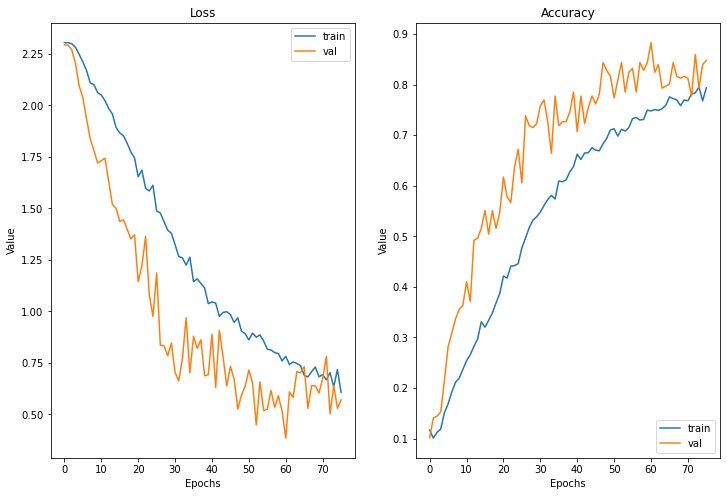

*******************number_5_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3088 - accuracy: 0.1011
Epoch 00001: val_loss improved from inf to 2.30287, saving model to model1_best_0.h5
56/56 [==============================] - 2s 27ms/step - loss: 2.3085 - accuracy: 0.1004 - val_loss: 2.3029 - val_accuracy: 0.0938 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3026 - accuracy: 0.1091
Epoch 00002: val_loss improved from 2.30287 to 2.29775, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.3024 - accuracy: 0.1099 - val_loss: 2.2977 - val_accuracy: 0.1055 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2980 - accuracy: 0.1250
Epoch 00003: val_loss improved from 2.29775 to 2.28309, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.2979 - accuracy: 0.1250 - val_loss:

56/56 [==============================] - 1s 22ms/step - loss: 1.4894 - accuracy: 0.4927 - val_loss: 0.8780 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4575 - accuracy: 0.4835
Epoch 00027: val_loss did not improve from 0.87795
56/56 [==============================] - 1s 20ms/step - loss: 1.4563 - accuracy: 0.4821 - val_loss: 1.0686 - val_accuracy: 0.6328 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.3938 - accuracy: 0.5165
Epoch 00028: val_loss did not improve from 0.87795
56/56 [==============================] - 1s 20ms/step - loss: 1.3901 - accuracy: 0.5173 - val_loss: 0.9474 - val_accuracy: 0.6836 - lr: 1.0000e-04
Epoch 29/300
55/56 [============================>.] - ETA: 0s - loss: 1.3762 - accuracy: 0.5165
Epoch 00029: val_loss improved from 0.87795 to 0.84890, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 1.3763 - accuracy:

Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 0.8148 - accuracy: 0.7318
Epoch 00054: val_loss did not improve from 0.52138
56/56 [==============================] - 1s 21ms/step - loss: 0.8144 - accuracy: 0.7310 - val_loss: 0.5511 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.7854 - accuracy: 0.7466
Epoch 00055: val_loss did not improve from 0.52138
56/56 [==============================] - 1s 21ms/step - loss: 0.7839 - accuracy: 0.7467 - val_loss: 0.5667 - val_accuracy: 0.8086 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.8516 - accuracy: 0.7324
Epoch 00056: val_loss did not improve from 0.52138
56/56 [==============================] - 1s 21ms/step - loss: 0.8526 - accuracy: 0.7310 - val_loss: 0.5399 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 57/300
55/56 [============================>.] - ETA: 0s - loss: 0.8080 - accuracy: 0.7284
Epoch 00057: val_loss 

Epoch 82/300
55/56 [============================>.] - ETA: 0s - loss: 0.6029 - accuracy: 0.8091
Epoch 00082: val_loss did not improve from 0.39193
56/56 [==============================] - 1s 21ms/step - loss: 0.6096 - accuracy: 0.8064 - val_loss: 0.5358 - val_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 83/300
55/56 [============================>.] - ETA: 0s - loss: 0.5994 - accuracy: 0.7989
Epoch 00083: val_loss did not improve from 0.39193
56/56 [==============================] - 1s 21ms/step - loss: 0.5987 - accuracy: 0.7985 - val_loss: 0.6114 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 84/300
55/56 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.7949
Epoch 00084: val_loss did not improve from 0.39193
56/56 [==============================] - 1s 21ms/step - loss: 0.5964 - accuracy: 0.7946 - val_loss: 0.6360 - val_accuracy: 0.8047 - lr: 1.0000e-04
Epoch 85/300
55/56 [============================>.] - ETA: 0s - loss: 0.5614 - accuracy: 0.8108
Epoch 00085: val_loss 

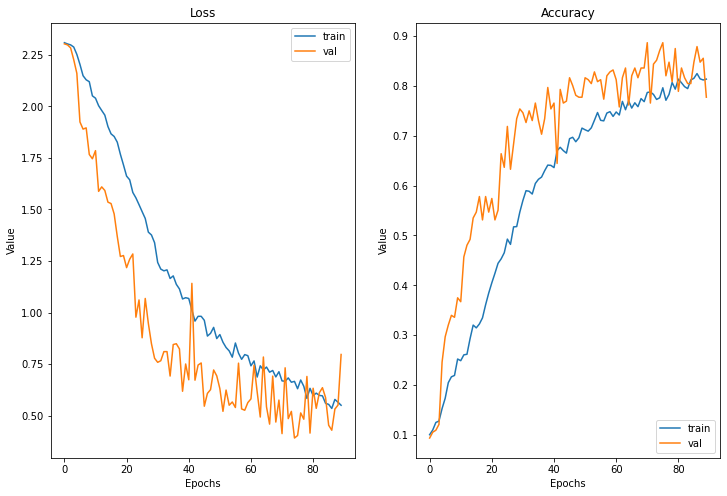

*******************number_6_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3070 - accuracy: 0.1119
Epoch 00001: val_loss improved from inf to 2.30539, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.3072 - accuracy: 0.1110 - val_loss: 2.3054 - val_accuracy: 0.0781 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.2947 - accuracy: 0.1114
Epoch 00002: val_loss did not improve from 2.30539
56/56 [==============================] - 1s 21ms/step - loss: 2.2947 - accuracy: 0.1127 - val_loss: 2.3124 - val_accuracy: 0.0781 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2946 - accuracy: 0.1142
Epoch 00003: val_loss improved from 2.30539 to 2.30097, saving model to model1_best_0.h5
56/56 [==============================] - 1s 24ms/step - loss: 2.2948 - accuracy: 0.1138 - val_loss: 2.3010 - val_accuracy: 0.0820 - lr: 1

Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4329 - accuracy: 0.5102
Epoch 00027: val_loss improved from 0.96104 to 0.89630, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 1.4335 - accuracy: 0.5089 - val_loss: 0.8963 - val_accuracy: 0.6992 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.4148 - accuracy: 0.5131
Epoch 00028: val_loss improved from 0.89630 to 0.85953, saving model to model1_best_0.h5
56/56 [==============================] - 1s 23ms/step - loss: 1.4146 - accuracy: 0.5134 - val_loss: 0.8595 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 29/300
55/56 [============================>.] - ETA: 0s - loss: 1.3673 - accuracy: 0.5466
Epoch 00029: val_loss did not improve from 0.85953
56/56 [==============================] - 1s 20ms/step - loss: 1.3732 - accuracy: 0.5452 - val_loss: 1.0152 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 30/300
55/56 [======================

55/56 [============================>.] - ETA: 0s - loss: 0.8337 - accuracy: 0.7295
Epoch 00054: val_loss did not improve from 0.62599
56/56 [==============================] - 1s 21ms/step - loss: 0.8362 - accuracy: 0.7294 - val_loss: 0.7998 - val_accuracy: 0.8086 - lr: 1.0000e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.8537 - accuracy: 0.7142
Epoch 00055: val_loss did not improve from 0.62599
56/56 [==============================] - 1s 21ms/step - loss: 0.8576 - accuracy: 0.7132 - val_loss: 0.8345 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.8227 - accuracy: 0.7142
Epoch 00056: val_loss did not improve from 0.62599
56/56 [==============================] - 1s 22ms/step - loss: 0.8211 - accuracy: 0.7132 - val_loss: 0.6908 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 57/300
55/56 [============================>.] - ETA: 0s - loss: 0.8060 - accuracy: 0.7290
Epoch 00057: val_loss did not impro

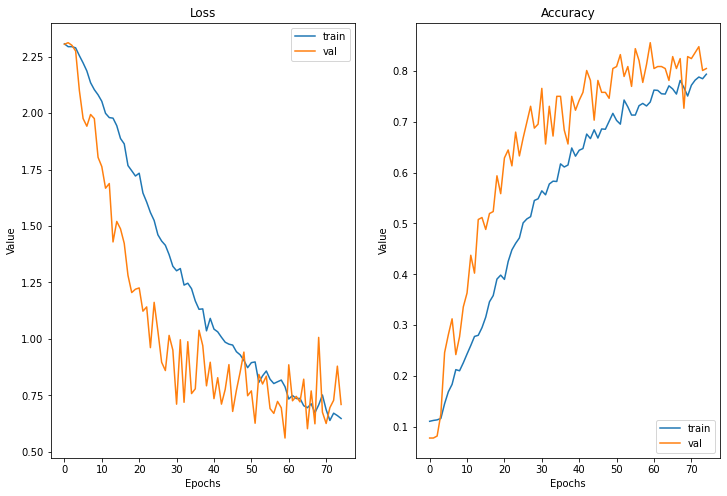

*******************number_7_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3073 - accuracy: 0.1023
Epoch 00001: val_loss improved from inf to 2.29836, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 2.3075 - accuracy: 0.1027 - val_loss: 2.2984 - val_accuracy: 0.1055 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3019 - accuracy: 0.1057
Epoch 00002: val_loss did not improve from 2.29836
56/56 [==============================] - 1s 20ms/step - loss: 2.3019 - accuracy: 0.1049 - val_loss: 2.2984 - val_accuracy: 0.1133 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2988 - accuracy: 0.1125
Epoch 00003: val_loss improved from 2.29836 to 2.28558, saving model to model1_best_0.h5
56/56 [==============================] - 1s 22ms/step - loss: 2.2988 - accuracy: 0.1122 - val_loss: 2.2856 - val_accuracy: 0.1328 - lr: 1

Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4724 - accuracy: 0.4858
Epoch 00027: val_loss improved from 0.95081 to 0.82787, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 1.4730 - accuracy: 0.4866 - val_loss: 0.8279 - val_accuracy: 0.7344 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.4143 - accuracy: 0.5034
Epoch 00028: val_loss did not improve from 0.82787
56/56 [==============================] - 1s 23ms/step - loss: 1.4189 - accuracy: 0.5028 - val_loss: 1.1305 - val_accuracy: 0.6758 - lr: 1.0000e-04
Epoch 29/300
55/56 [============================>.] - ETA: 0s - loss: 1.4016 - accuracy: 0.5284
Epoch 00029: val_loss did not improve from 0.82787
56/56 [==============================] - 1s 23ms/step - loss: 1.4023 - accuracy: 0.5285 - val_loss: 0.9895 - val_accuracy: 0.6719 - lr: 1.0000e-04
Epoch 30/300
55/56 [============================>.] - ETA: 0s - loss: 1.3275 - a

Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 0.8511 - accuracy: 0.7176
Epoch 00055: val_loss improved from 0.54904 to 0.51113, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 0.8548 - accuracy: 0.7165 - val_loss: 0.5111 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 56/300
55/56 [============================>.] - ETA: 0s - loss: 0.8044 - accuracy: 0.7335
Epoch 00056: val_loss did not improve from 0.51113
56/56 [==============================] - 1s 23ms/step - loss: 0.8060 - accuracy: 0.7321 - val_loss: 0.6954 - val_accuracy: 0.7930 - lr: 1.0000e-04
Epoch 57/300
55/56 [============================>.] - ETA: 0s - loss: 0.8072 - accuracy: 0.7375
Epoch 00057: val_loss did not improve from 0.51113
56/56 [==============================] - 1s 23ms/step - loss: 0.8085 - accuracy: 0.7377 - val_loss: 0.7834 - val_accuracy: 0.7539 - lr: 1.0000e-04
Epoch 58/300
55/56 [============================>.] - ETA: 0s - loss: 0.8086 - a

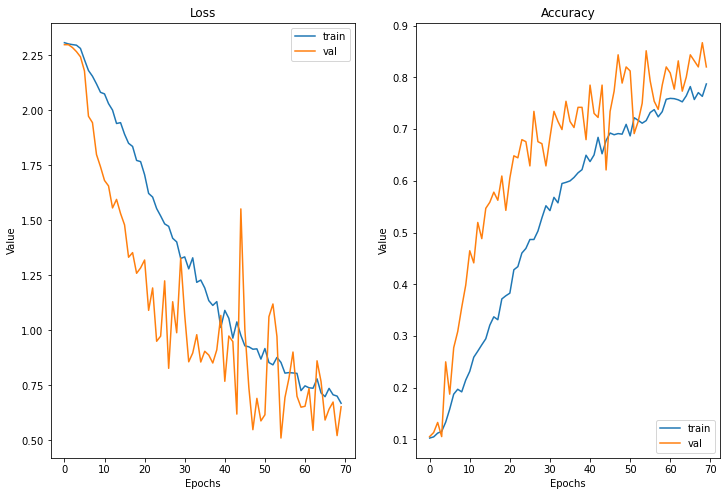

*******************number_8_kfold_model*******************
Epoch 1/300
55/56 [============================>.] - ETA: 0s - loss: 2.3100 - accuracy: 0.1085
Epoch 00001: val_loss improved from inf to 2.29345, saving model to model1_best_0.h5
56/56 [==============================] - 2s 27ms/step - loss: 2.3098 - accuracy: 0.1088 - val_loss: 2.2934 - val_accuracy: 0.1445 - lr: 1.0000e-04
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.3040 - accuracy: 0.1148
Epoch 00002: val_loss improved from 2.29345 to 2.29142, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 2.3039 - accuracy: 0.1133 - val_loss: 2.2914 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.2997 - accuracy: 0.1131
Epoch 00003: val_loss improved from 2.29142 to 2.28488, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 2.3003 - accuracy: 0.1110 - val_loss:

Epoch 26/300
55/56 [============================>.] - ETA: 0s - loss: 1.5376 - accuracy: 0.4722
Epoch 00026: val_loss improved from 1.09258 to 1.07199, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 1.5336 - accuracy: 0.4727 - val_loss: 1.0720 - val_accuracy: 0.6836 - lr: 1.0000e-04
Epoch 27/300
55/56 [============================>.] - ETA: 0s - loss: 1.4845 - accuracy: 0.4812
Epoch 00027: val_loss improved from 1.07199 to 1.04017, saving model to model1_best_0.h5
56/56 [==============================] - 1s 26ms/step - loss: 1.4841 - accuracy: 0.4816 - val_loss: 1.0402 - val_accuracy: 0.6680 - lr: 1.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.4705 - accuracy: 0.4784
Epoch 00028: val_loss improved from 1.04017 to 0.89180, saving model to model1_best_0.h5
56/56 [==============================] - 1s 25ms/step - loss: 1.4631 - accuracy: 0.4821 - val_loss: 0.8918 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoc

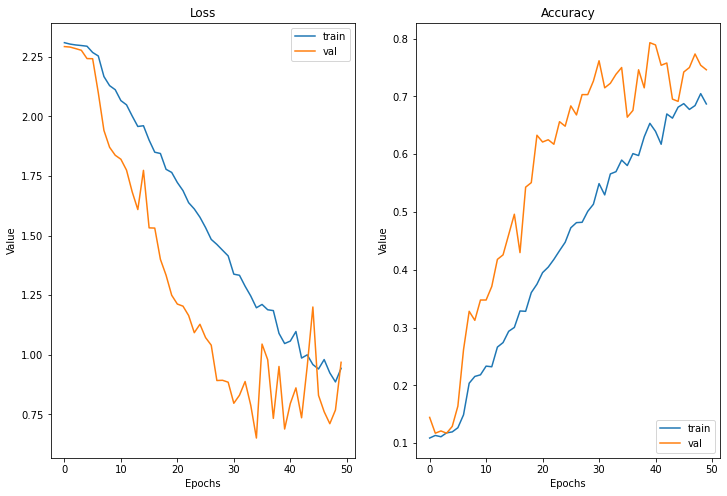

In [12]:
RS_train, RS_test = get_stacking(ResNet, X_trains, y_trains)

## Pickle 파일 저장

In [13]:
pickle.dump(RS_train, open("./pickle/RS_train.pkl", "wb"))
pickle.dump(RS_test, open("./pickle/RS_test.pkl", "wb"))